# Features x & y : Players performance

In [11]:
from urllib.parse import unquote
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

/home/Armonis/Documents/EPFL/Adamants/Project


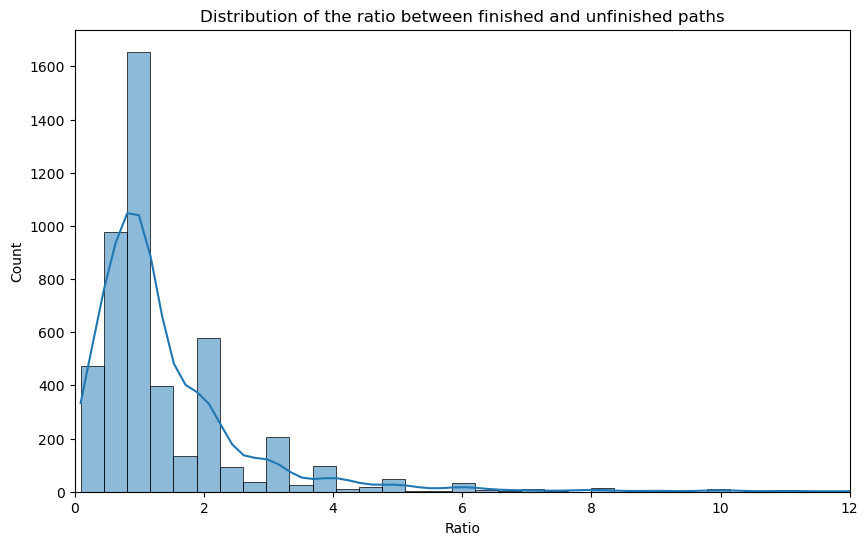

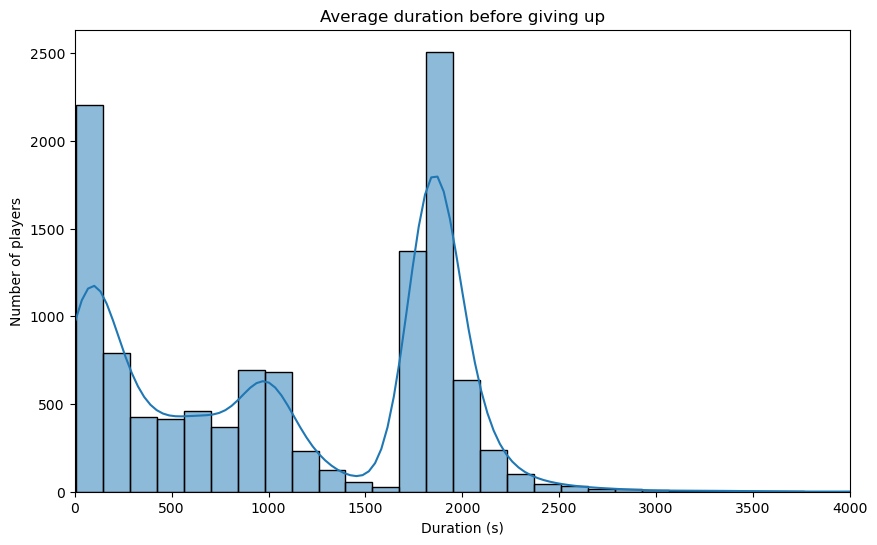

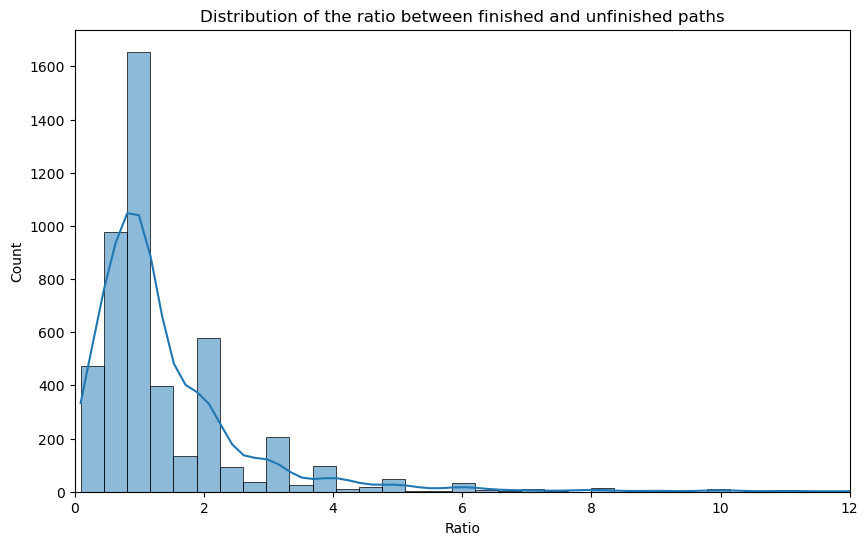

<Figure size 1000x600 with 0 Axes>

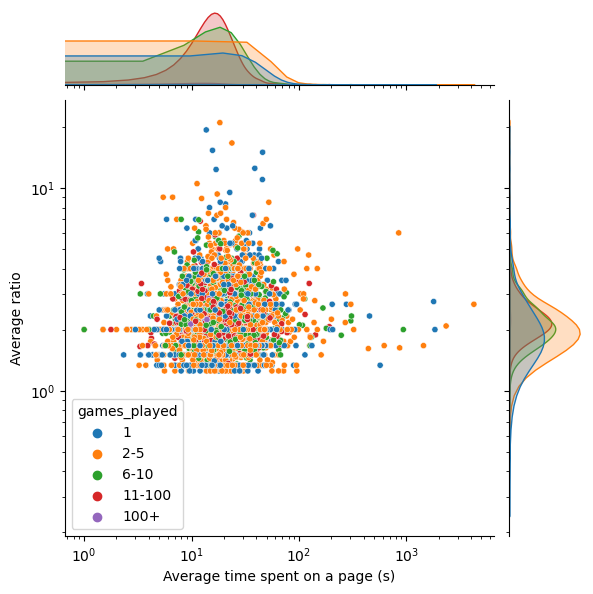

<Figure size 1000x600 with 0 Axes>

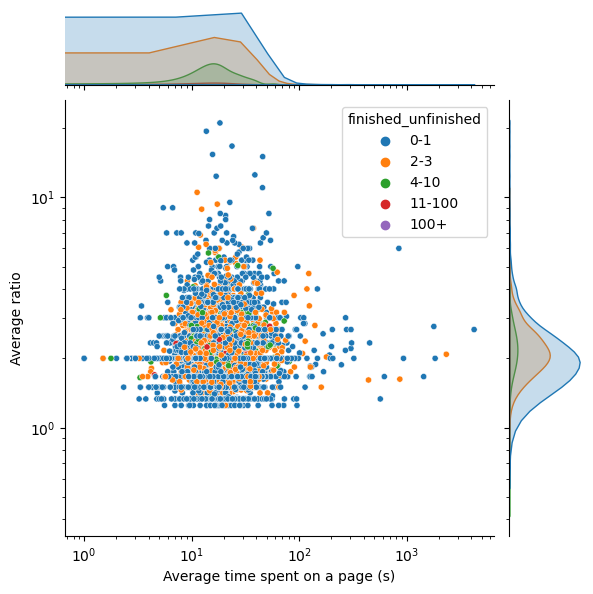

<Figure size 1000x600 with 0 Axes>

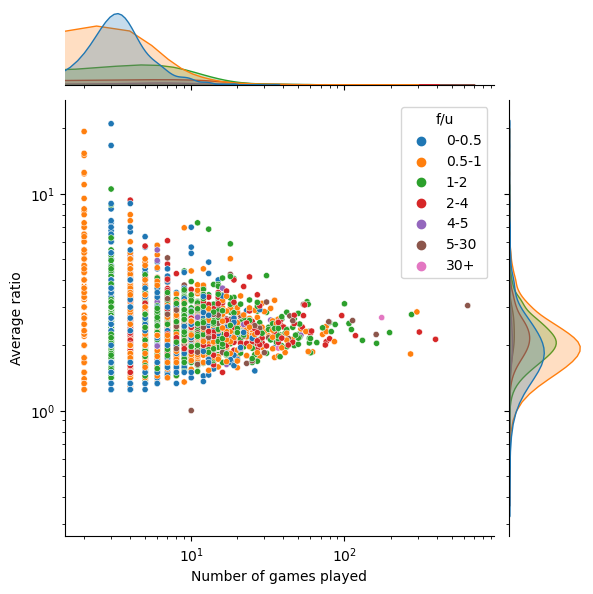

In [19]:
### Loading the data ###
PATH = Path.cwd()
PATH = PATH.parent
print(PATH)
DATA_PATH = PATH / "data/wikispeedia_paths-and-graph/"
shortest_path = (DATA_PATH / "shortest-path-distance-matrix.txt").resolve()
PATHS_FINISHED = (DATA_PATH / "paths_finished.tsv").resolve()
PATHS_UNFINISHED = (DATA_PATH / "paths_unfinished.tsv").resolve()

assert shortest_path.is_file()
shortest_path = np.loadtxt(shortest_path, dtype=str)

links_path = (DATA_PATH / "links.tsv").resolve()
assert links_path.is_file()
links = pd.read_csv(
    links_path,
    sep="\t",
    header=None,
    names=["from", "to"],
    skiprows=11,
    skip_blank_lines=True,
)

articles_path = (DATA_PATH / "articles.tsv").resolve()
assert articles_path.is_file()
articles = pd.read_csv(
    articles_path,
    sep="\t",
    header=None,
    names=["name"],
    skiprows=11,
    skip_blank_lines=True,
)


def convert_to_matrix(data):
    """Replaces each row (string) with the integer values of the string and replaces _ with NaN"""
    data = np.array([[int(i) if i != "_" else np.nan for i in row] for row in data])
    return data


def parse_paths(dataframe):
    """Parses the path column into a list of strings"""
    dataframe["path"] = dataframe["path"].map(lambda x: x.split(";"))
    return dataframe


shortest_path_matrix = convert_to_matrix(shortest_path)


def compare_paths(user_path):
    """Looks up for the optimal path and compares it to the user path."""
    start, end = user_path[0], user_path[-1]
    try:
        shortest_p = shortest_path_df.loc[start, end]
        if shortest_p == 0:
            shortest_p = 1  # FIXME
        elif np.isnan(shortest_p):
            return np.nan
    except KeyError:
        return np.nan
    user_len = len(user_path)
    if np.isnan(shortest_p):
        return np.nan
    return user_len / shortest_p


def average_ratio(dataframe):
    """Calculates the average ratio for each player"""
    dataframe = dataframe.groupby("hashedIpAddress").agg(
        {
            "ratio": "mean",
            "path": "count",
            "durationInSec": "mean",
            "average_time_on_page": "mean",
        }
    )
    dataframe = dataframe.rename(columns={"path": "count"})
    dataframe = dataframe.rename(columns={"durationInSec": "mean_duration"})
    return dataframe


def player_unfinished(dataframe):
    """Calculates the number of unfinished paths and giving up time average for each player"""
    dataframe = dataframe.groupby("hashedIpAddress").agg(
        {"path": "count", "durationInSec": "mean"}
    )
    dataframe = dataframe.rename(columns={"path": "count"})
    dataframe = dataframe.rename(columns={"durationInSec": "mean_duration"})
    return dataframe


### Data Exploration ###
paths_finished = pd.read_csv(
    PATHS_FINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    encoding="utf-8",
    skiprows=16,
).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit="s")
paths_finished = parse_paths(paths_finished)
paths_finished["path"] = paths_finished["path"].apply(lambda x: [unquote(i) for i in x])

paths_unfinished = pd.read_csv(
    PATHS_UNFINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    encoding="utf-8",
    skiprows=17,
).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit="s")
paths_unfinished = parse_paths(paths_unfinished)
paths_unfinished["path"] = paths_unfinished["path"].apply(
    lambda x: [unquote(i) for i in x]
)

# Unquote article names
articles.name = articles.name.apply(unquote)
# Add a column for each article name, and fill the dataframe with shortest path distances
shortest_path_df = pd.DataFrame(
    shortest_path_matrix, index=articles.name, columns=articles.name
)

# For each player, calculate the ratio between the length of the path and the shortest path
paths_finished = paths_finished.copy(deep=True)
paths_finished["ratio"] = paths_finished["path"].apply(compare_paths)
paths_finished["path_len"] = paths_finished["path"].apply(len)
paths_finished["average_time_on_page"] = (
    paths_finished["durationInSec"] / paths_finished["path_len"]
)

players_finished = average_ratio(paths_finished)
players_unfinished = player_unfinished(paths_unfinished.copy(deep=True))

# Merge the two dataframes
players = players_finished.merge(
    players_unfinished, how="outer", left_index=True, right_index=True
)
players = players.rename(
    columns={"count_x": "count_finished", "count_y": "count_unfinished"}
)
players = players.rename(
    columns={
        "mean_duration_x": "mean_duration_finished",
        "mean_duration_y": "mean_duration_unfinished",
    }
)

finished_unfinished = players[["count_finished", "count_unfinished"]].copy(deep=True)
finished_unfinished = finished_unfinished.dropna()
finished_unfinished["ratio"] = (
    finished_unfinished["count_finished"] / finished_unfinished["count_unfinished"]
)

### Plots ###

# Plot the distribution of the ratio
plt.figure(figsize=(10, 6))
sns.histplot(data=finished_unfinished, x="ratio", bins=100, kde=True)
plt.title("Distribution of the ratio between finished and unfinished paths")
plt.xlabel("Ratio")
plt.xlim(0, 12)
plt.ylabel("Count")
plt.show()

# Histogram of the average duration before giving up
players_unfinished = players[players["count_unfinished"] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(players_unfinished["mean_duration_unfinished"], kde=True)
plt.title("Average duration before giving up")
plt.xlabel("Duration (s)")
plt.xlim(0, 4000)
plt.ylabel("Number of players")
plt.show()

players_paths = players.copy(deep=True)
players_paths["ratio-f-u"] = (
    players_paths["count_finished"] / players_paths["count_unfinished"]
)

plt.figure(figsize=(10, 6))
sns.histplot(data=players_paths, x="ratio-f-u", bins=100, kde=True)
plt.title("Distribution of the ratio between finished and unfinished paths")
plt.xlabel("Ratio")
plt.xlim(0, 12)
plt.ylabel("Count")
plt.show()

# Plot of a scatterplot of the average path ratio and the average time spent on a page, with the number of games played as the color of the points
players_games_played = players.copy(deep=True)
players_games_played["games_played"] = (
    players_games_played["count_finished"] + players_games_played["count_unfinished"]
)
players_games_played["games_played"] = pd.cut(
    players_games_played["games_played"],
    bins=[1, 2, 5, 10, 100, 10000],
    labels=["1", "2-5", "6-10", "11-100", "100+"],
)
plt.figure(figsize=(10, 6))
sns.jointplot(
    data=players_games_played,
    x="average_time_on_page",
    y="ratio",
    hue="games_played",
    s=20,
)
plt.xlabel("Average time spent on a page (s)")
plt.xscale("log")
plt.ylabel("Average ratio")
plt.yscale("log")
plt.show()

# Plot of a scatterplot of the average path ratio and the average time spent on a page, with the number of games played as the color of the points
players_finished_unfinished = players.copy(deep=True)
players_finished_unfinished["count_unfinished"] = players_finished_unfinished[
    "count_unfinished"
].dropna()
players_finished_unfinished["count_finished"] = players_finished_unfinished[
    "count_finished"
].dropna()
players_finished_unfinished["finished_unfinished"] = (
    players_finished_unfinished["count_finished"]
    / players_finished_unfinished["count_unfinished"]
)
players_finished_unfinished["finished_unfinished"] = pd.cut(
    players_finished_unfinished["finished_unfinished"],
    bins=[0, 1, 3, 10, 100, 10000],
    labels=["0-1", "2-3", "4-10", "11-100", "100+"],
)
plt.figure(figsize=(10, 6))
sns.jointplot(
    data=players_finished_unfinished,
    x="average_time_on_page",
    y="ratio",
    hue="finished_unfinished",
    s=20,
)
plt.xlabel("Average time spent on a page (s)")
plt.xscale("log")
plt.ylabel("Average ratio")
plt.yscale("log")
plt.show()






<Figure size 1000x600 with 0 Axes>

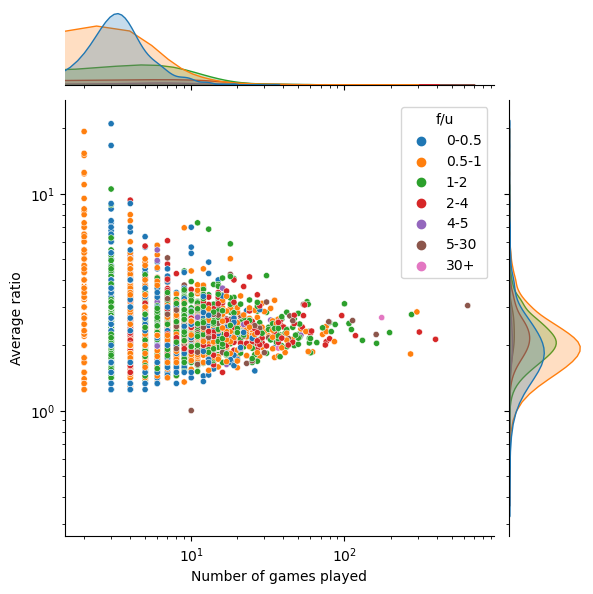

In [20]:
players_games_played = players.copy(deep=True)
players_games_played["games_played"] = (
    players_games_played["count_finished"] + players_games_played["count_unfinished"]
)
players_games_played["f/u"] = (
    players_games_played["count_finished"] / players_games_played["count_unfinished"]
)
players_games_played["f/u"] = pd.cut(
    players_games_played["f/u"],
    bins=[0, 0.5, 1, 2, 4, 5, 30, 10000],
    labels=["0-0.5", "0.5-1", "1-2", "2-4", "4-5", "5-30", "30+"],
)
players_games_played = players_games_played[players_games_played["games_played"] > 0]

plt.figure(figsize=(10, 6))
sns.jointplot(data=players_games_played, x="games_played", y="ratio", hue="f/u", s=20)
plt.xlabel("Number of games played")
plt.xscale("log")
plt.ylabel("Average ratio")
plt.yscale("log")
plt.show()

Plot of the players

### Finished / Unfinished Path Ratio
    We see the distribution of the ratio of finished / unfisnished path is between 1 and 2.
### Duration between giving up
    The players are giving up early maybe when they see the difficulty of the path. And the second peak is the server time out.
### Duration on a page.
    The majority of the players are spending less than 30 seconds on a page.
    